#### This exercise was performed on ARCC Beartooth with the following environment/software packages: 

#### Load Preinstalled Modules:
module load gcc12.2.0 miniconda3 git/2.37.0

#### Create environment then activate with:
conda env create -f whatev_ml_env.yml \
conda activate whatev_ml_env

#### Make sure jupyter can see the kernel in your conda env so you can select from southpass interface dropdown:
python -m ipykernel install --user --name=whatev_conda_torch 

#### Download data to folder and extract
wget https://archive.ics.uci.edu/static/public/186/wine+quality.zip \
unzip wine+quality.zip


In [47]:
#importing all necessary libraries
import os,sys,platform
import numpy as np
import pandas as pd
import tqdm #A progress bar
import matplotlib.pyplot as plt
import torch as torch

#For our ML Model Blueprint
from sklearn import svm, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

#Tools for data processing and model evaluation metrics
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, ValidationCurveDisplay, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse # for Linear Regression 
from sklearn.metrics import explained_variance_score as evs # for Linear Regression Evaluation
from sklearn.metrics import accuracy_score as score # for Classification
from sklearn.metrics import confusion_matrix as cm # for Classification
from sklearn.metrics import ConfusionMatrixDisplay as showMatrix # for Classification

In [37]:
#confirm and checking platform and sotware versions in software stack
print(f"Python Platform:{platform.platform()}")
print(f"Python {sys.version}")
print(f"PyTorch Version: ", torch.__version__)
print(f"Pandas Version: " , pd.__version__)

Python Platform:Linux-4.18.0-513.11.1.el8_9.x86_64-x86_64-with-glibc2.28
Python 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
PyTorch Version:  2.1.2
Pandas Version:  2.1.4


In [38]:
#checking devices available

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
# Pretty-print the names
for i in available_gpus:
    print(torch.cuda.get_device_properties(i).name)

# Prints 'Tesla V100-SXM2-16GB', for example
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

Tesla T4
12.1
Using device:  cuda


# Warmup

Download the [Wine Quality
dataset](https://archive.ics.uci.edu/dataset/186/wine+quality). Choose the
one that corresponds to your preference in wine.

Downloaded and unzipped to folder/repo

In [39]:
#Import data and separate out
data = pd.read_csv('winequality-red.csv',sep=';')

#view data, get info about it, clean if necessary
data.info()
data.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1589,6.6,0.725,0.20,7.8,0.073,29.0,79.0,0.99770,3.29,0.54,9.2,5
1590,6.3,0.550,0.15,1.8,0.077,26.0,35.0,0.99314,3.32,0.82,11.6,6
1591,5.4,0.740,0.09,1.7,0.089,16.0,26.0,0.99402,3.67,0.56,11.6,6
1592,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

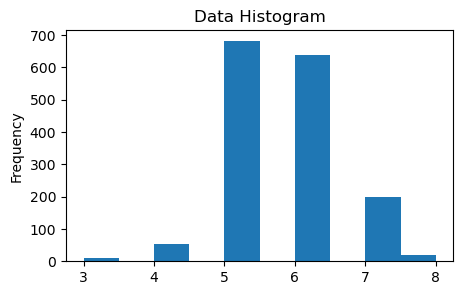

In [40]:
#data looks good, export and pull label data from rest of the dataset
labels = data.pop("quality")
display(labels) #should be a list of int64s

#Show a histogram of the distribution of label data
plot = labels.plot(kind='hist', title="Data Histogram", figsize=(5,3))

## Regression

Build a regression model to predict the wine quality. You can choose any model
type you like; the purpose of this exercise is to get you started. Evaluate the
performance of your trained model -- make sure to get an unbiased performance
estimate!

In [41]:
#Initial Regression Model to Predict Wine Quality Using sklearn linear regression prepackaged ML
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

#AKA'ing our data into X features and y labels
#Uses train_test_split for model evals and use to shuffle our data and randomize what gets parsed to test and train
X_train_raw, X_test_raw, y_train, y_test = train_test_split(data, labels, train_size=.75, shuffle=True,random_state=0)

The Linear Regression Model Prediction Score is:  0.3632493675603261
The Linear Regression Model Explained Variance Score is:  0.35006835112199897
The accuracy for this Linear Regression Model is:  0.400072527085055
the R2 Score for this Linear Regression Model is:  0.345424381245628


<Figure size 640x480 with 0 Axes>

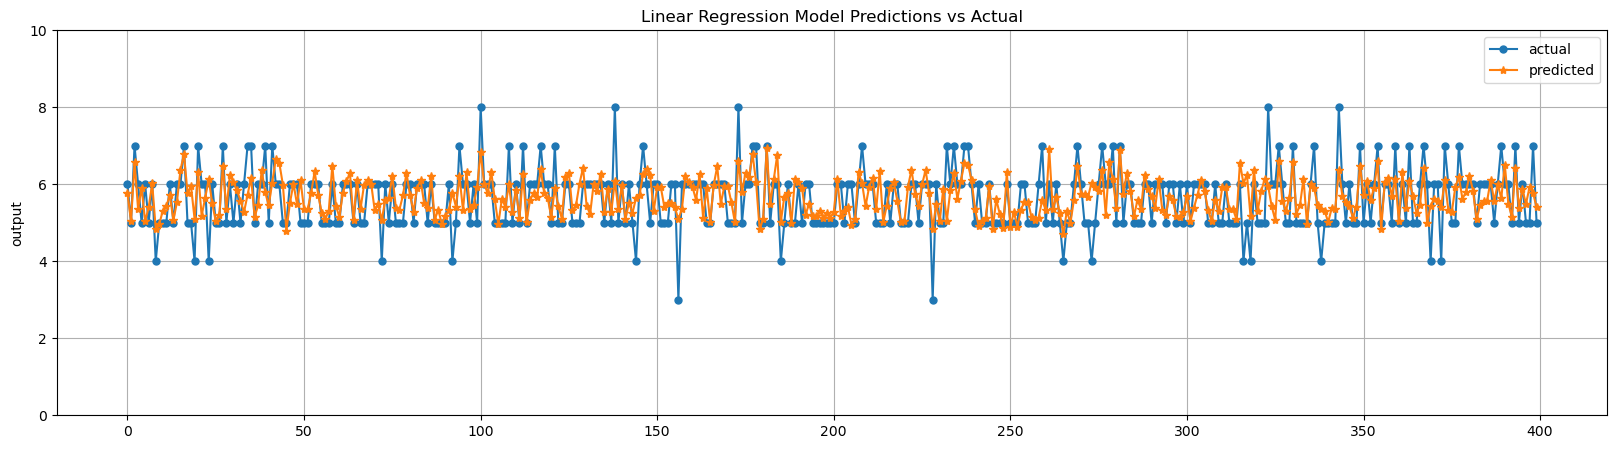

The Linear Regression Model Explained Variance Score is:  0.25147508461923884
The accuracy for this Linear Regression Model is:  0.4575
the R2 Score for this Linear Regression Model is:  0.251464858729331


<Figure size 640x480 with 0 Axes>

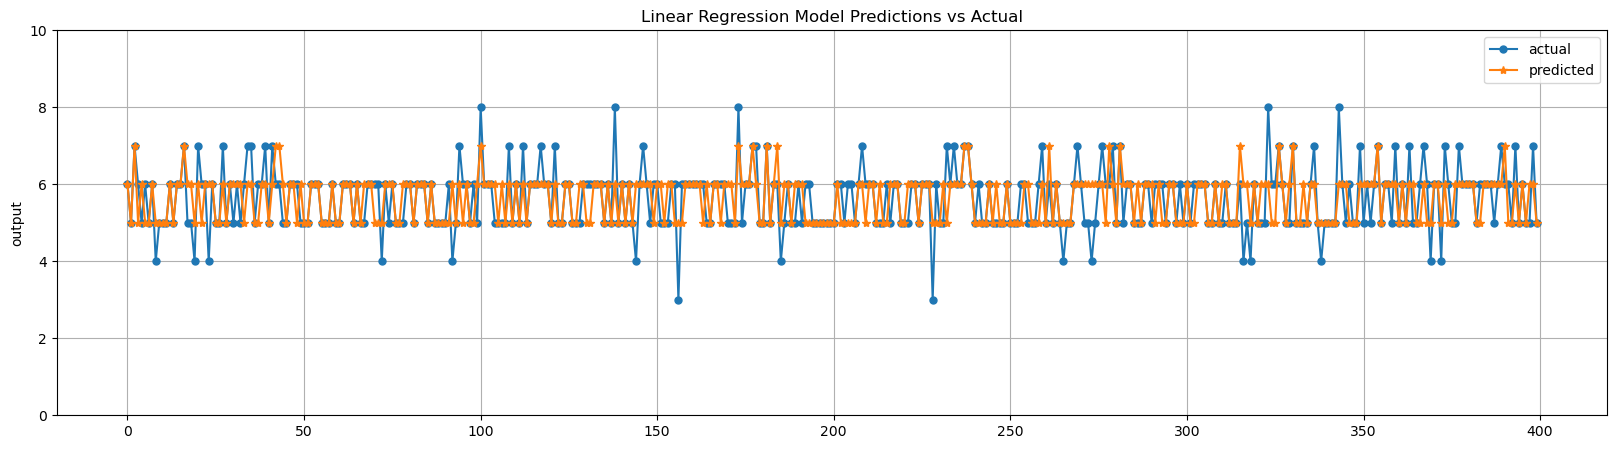

In [50]:
#Make a simple linear regression model called lr and fit it on training data
lr = linear_model.LinearRegression()
lr.fit(X_train_raw, y_train)

lrPredictions = lr.predict(X_test_raw)

lrModelScore = lr.score(X_train_raw, y_train) #Gets coefficient of determination of the prediction - Here that's the R2 Score
lrR2 = r2(y_test, lrPredictions) #Gets the R2 Score
lr_exp_variance = evs(y_test, lrPredictions) # Get Explained Variance Score
#We need to convert our y_actual values to plot them correctly.
y_test_np = y_test.to_numpy()

print("The Linear Regression Model Prediction Score is: ", lrModelScore)
print("The Linear Regression Model Explained Variance Score is: ", lr_exp_variance) 

wineLRAccuracy = mse(y_test, lrPredictions)
print("The accuracy for this Linear Regression Model is: ", wineLRAccuracy)
print("the R2 Score for this Linear Regression Model is: ", lrR2)

plt.clf()
plt.figure(figsize=(20,5))
plt.title("Linear Regression Model Predictions vs Actual")
plt.plot(y_test_np, label="actual", marker="o", markersize=5)
plt.plot(lrPredictions, label="predicted", marker="*")
plt.ylabel("output")
plt.ylim(0,10)
plt.grid(True)
plt.legend()
plt.show()

#Adjust the predictions list so that all predicted values are rounded to the nearest whole number.
roundPredictions = np.around(lrPredictions, decimals=0)

roundR2 = r2(y_test, roundPredictions) #Gets the R2 Score
round_exp_variance = evs(y_test, roundPredictions) # Get Explained Variance Score
#We need to convert our y_actual values to plot them correctly.

print("The Linear Regression Model Explained Variance Score is: ", round_exp_variance) 

roundLRAccuracy = mse(y_test, roundPredictions)
print("The accuracy for this Linear Regression Model is: ", roundLRAccuracy)
print("the R2 Score for this Linear Regression Model is: ", roundR2)

plt.clf()
plt.figure(figsize=(20,5))
plt.title("Linear Regression Model Predictions vs Actual")
plt.plot(y_test_np, label="actual", marker="o", markersize=5)
plt.plot(roundPredictions, label="predicted", marker="*")
plt.ylabel("output")
plt.ylim(0,10)
plt.grid(True)
plt.legend()
plt.show()



## Classification

Now predict the wine quality as a class, i.e. model the problem as a
classification problem. Evaluate the performance of your trained model again.

In [43]:
#Initial Classification Model to Predict Wine Quality Using sklearn linear regression prepackaged ML
#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm

#AKA'ing our data into X features and y labels
#Uses train_test_split for model evals and use to shuffle our data and randomize what gets parsed to test and train
X_train_raw, X_test_raw, y_train, y_test = train_test_split(data, labels, train_size=.75, shuffle=True,random_state=0)

[6 5 6 5 6 5 5 6 5 5 5 5 6 5 5 6 6 6 6 5 6 5 6 6 5 5 5 6 5 6 6 6 6 5 6 6 5
 5 6 6 5 6 6 6 6 5 5 6 5 6 5 5 6 6 6 5 5 5 6 5 5 6 6 6 5 6 5 6 6 6 5 5 5 5
 5 6 5 5 5 6 6 5 6 6 5 5 6 5 5 5 5 5 6 5 6 5 6 5 5 6 6 6 6 6 6 5 6 5 6 5 6
 5 6 5 6 6 6 6 6 6 5 6 5 5 6 6 5 5 6 6 5 5 6 6 6 5 6 5 6 5 6 5 5 5 5 6 6 6
 6 5 6 6 5 6 6 6 5 5 6 6 6 5 6 5 6 5 6 6 5 6 6 5 5 6 6 6 6 6 6 5 5 6 5 6 6
 5 5 6 5 6 6 6 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 5 6 6 5 6 5 5 6 6 6 5 5 6
 6 6 5 6 6 6 5 5 5 6 5 6 6 6 6 6 6 6 5 5 5 5 6 5 5 5 5 6 5 5 5 5 5 5 5 5 5
 6 5 6 5 5 5 5 5 5 6 6 6 5 5 6 6 6 6 5 6 6 5 6 5 6 6 5 5 5 6 6 6 6 6 5 5 6
 5 5 5 5 6 5 5 5 6 6 5 5 5 5 6 6 5 5 5 6 6 6 5 6 5 6 6 6 6 5 6 5 5 5 6 5 5
 6 5 6 6 5 5 5 5 5 5 6 6 5 5 5 5 6 6 6 5 6 6 5 6 6 6 6 5 6 5 6 6 5 5 6 5 5
 6 6 5 6 5 5 6 6 6 6 6 6 5 5 5 6 6 5 6 5 6 5 5 6 5 6 5 6 6 5]
400
[6 5 7 6 5 6 5 6 4 5 5 5 6 5 6 6 7 5 5 4 7 6 6 4 6 5 5 7 5 6 5 6 5 6 7 7 5
 6 6 7 5 7 6 6 5 5 6 6 6 5 5 5 6 6 6 5 5 5 6 5 5 6 6 6 5 6 5 5 6 6 6 6 4 6
 5 6 5 5 5 6 6 5 6 6 6 5 6 5 5 5 5

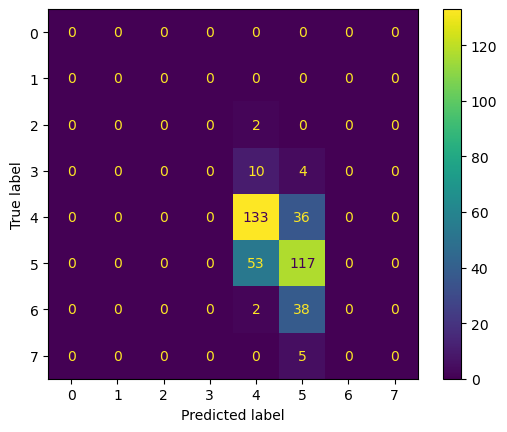

In [51]:
#Create a classification model named classify with a linear kernel
classify = svm.SVC(kernel="linear", gamma='auto', C=1)
classify.fit(X_train_raw, y_train)
classPredictions = classify.predict(X_test_raw)

classModelScore = classify.score(X_train_raw, y_train) #Return the mean accuracy on the given test data and labels.

print(classPredictions)
print(len(classPredictions))
flat_y = y_test.to_numpy() #flattened version (1D List of y_test labels)
print(flat_y)
print("The classification score for this Classification Model is: ", classModelScore)

wineClassAccuracy = score(y_test, classPredictions)  #Accuracy score for classification
print("The accuracy for this Classification Model is: ", wineClassAccuracy)


wineClassConfMatrix = cm(y_test, classPredictions, labels=[1,2,3,4,5,6,7,8])
disp=showMatrix(wineClassConfMatrix)
disp.plot()
plt.show()


[5 3 7 6 5 6 6 6 6 6 5 5 5 5 5 6 7 6 7 6 6 6 6 5 6 5 6 6 5 6 6 6 6 6 7 6 5
 5 6 6 5 7 5 5 6 5 5 6 6 6 5 5 6 6 5 5 5 5 7 5 5 6 6 7 6 6 5 5 7 6 5 5 6 5
 6 6 5 5 5 6 5 5 5 6 6 6 5 5 5 5 5 6 6 5 7 5 5 6 5 5 7 5 6 6 5 6 5 5 6 5 6
 5 6 5 5 7 5 7 7 6 5 7 4 5 7 6 5 5 5 6 5 5 6 5 6 5 6 5 6 5 6 6 5 6 5 6 6 7
 6 6 6 5 5 5 6 6 7 6 5 6 6 6 5 6 5 5 6 8 6 7 5 3 6 7 5 6 5 7 7 5 5 6 6 6 7
 5 6 6 5 6 5 5 5 5 5 5 5 5 5 5 6 7 6 6 5 5 6 6 6 6 5 5 5 5 5 6 5 6 5 5 5 5
 7 7 6 5 5 5 5 5 5 6 5 7 7 6 6 6 7 7 6 5 6 6 6 5 4 5 5 5 5 6 5 6 5 5 5 5 5
 7 5 6 5 5 5 5 6 5 6 5 5 5 6 5 6 6 7 6 6 7 6 5 5 5 5 5 5 5 6 6 5 5 6 6 5 6
 5 7 4 6 6 5 6 4 5 5 5 5 6 5 5 6 5 6 5 6 5 6 5 7 5 5 6 7 6 7 7 5 5 5 6 5 5
 6 5 5 7 6 5 6 5 6 5 6 6 5 6 5 5 6 6 6 5 7 6 6 5 6 6 7 6 5 6 5 5 6 5 6 5 5
 6 5 5 6 5 5 5 6 6 5 6 6 5 6 5 6 7 5 6 5 6 5 5 7 6 6 5 5 6 5]
[6 5 7 6 5 6 5 6 4 5 5 5 6 5 6 6 7 5 5 4 7 6 6 4 6 5 5 7 5 6 5 6 5 6 7 7 5
 6 6 7 5 7 6 6 5 5 6 6 6 5 5 5 6 6 6 5 5 5 6 5 5 6 6 6 5 6 5 5 6 6 6 6 4 6
 5 6 5 5 5 6 6 5 6 6 6 5 6 5 5 5 5 6 4

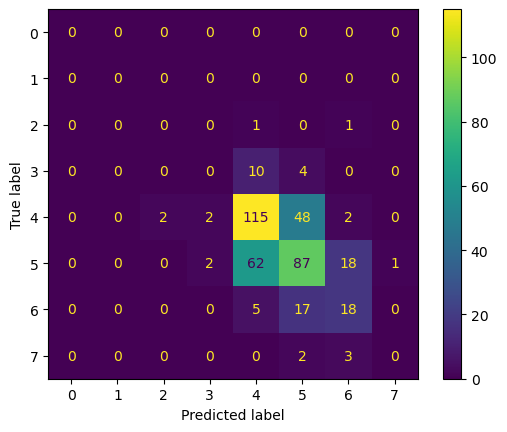

In [52]:
#Create a classification model named classify but use a Radial Kernel
classify = svm.SVC(kernel="rbf", gamma='auto', C=5)
classify.fit(X_train_raw, y_train)
classPredictions = classify.predict(X_test_raw)

classModelScore = classify.score(X_train_raw, y_train) #Return the mean accuracy on the given test data and labels.

print(classPredictions)
flat_y = y_test.to_numpy() #flattened version (1D List of y_test labels)
print(flat_y)
print("The classification score for this Classification Model is: ", classModelScore)

wineClassAccuracy = score(y_test, classPredictions)  #Accuracy score for classification
print("The accuracy for this Classification Model is: ", wineClassAccuracy)


wineClassConfMatrix = cm(y_test, classPredictions, labels=[1,2,3,4,5,6,7,8])
disp=showMatrix(wineClassConfMatrix)
disp.plot()
plt.show()

## Submission

Upload your code and a brief description of your results.

### Linear Regression Model Evaluation:
This initial exercise uses the most basic of models (A Linear Logistic Regression Model).  It is recognized that this is far from an ideal model for this particular prediction problem and dataset.  The idea was to show a very naively developed model, which should result in very poor performance, and then see how to improve upon it.    

##### Metrics Used:  
For the Linear Regression Model, we use the following metrics for model evaluation.
1. Model Prediction Score:
Per [SciKitLearn's Website](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), The score() method "returns the mean accuracy on the given test data and labels."  Additionally, when performing multi label classification, "this references the subset accuracy which is a harsh metric since it requires each that each label set be correctly predicted for each sample".  

2. Explained Variance Score:
Per [SciKitLearn's Website](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html#sklearn.metrics.explained_variance_score), This metric essentially represents the amount of variation in the original dataset that our model is able to explain. 

3. MSE Score: 
Per [SciKitLearn's Website](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html#sklearn.metrics.root_mean_squared_error), this calculates the mean squared error regression loss on the model.  

4. R2 Score: 
Per [SciKitLearn's Website](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score), this returns the coefficient of determination on the regression model.


##### Accuracy: 
The above scores are all metrics to compute the accuracy of the overall model.  Run output is as follows: 

1. The Linear Regression Model Prediction Score is:  0.3632493675603261
2. The Linear Regression Model Explained Variance Score is:  0.35006835112199897
3. The accuracy for this Linear Regression Model is:  0.400072527085055
4. The R2 Score for this Linear Regression Model is:  0.345424381245628

As expected, all evaluation values indicate this model does not predict our labels well.  Overall, simple Linear Regression is not a great predictor of wine quality.  This is for several reasons.  One may suspect it's because the true values of each label are whole numbers while the predictions are all float values.  

If this were the case, we could improve the total accuracy score if we adjust the predicted values to round to the nearest whole number.  While we are able to make a small improvement on this front, this does not improve our other scores. Output for R2 and Explained Variance actually decrease as shown:  

1. The Linear Regression Model Explained Variance Score is:  0.25147508461923884
2. The accuracy for this Linear Regression Model is:  0.4575
3. The R2 Score for this Linear Regression Model is:  0.251464858729331

Additionally, the linear regression model in general is very bad at predicting lower quality wines.  All predicted values tend to fall between 5 and 7, and no values under quality 5 are ever predicted correctly.

##### Summary:  
The Linear Regression model developed is not a good predictor of wine quality and fails to accurately predict true wine quality in a majority of cases on test data.  


### Classification Model Evaluation
This particular classification model was designed using a classification support vector machine (svc-SVM).  Two different kernel selections were made but other hyperparameters remain constant.   Our kernel = linear in our first run, and kernel = rbf (radial) in the second.  In both classification models, we set gamma = auto, and C = 5.  

In the first case of classification a linear kernel is selected as it is the most simple of kernel functions using a linear decision plane.  

The second case of classification we selected a radial kernel (rbf).  This kernel requires C and gamma.  C is our trade off value for misclassifying.  Giving C a lower value will make our decision surface "softer" while a higher value for C sets a higher value for classifying our training examples correctly.  Setting the value to 5 is somewhat on the higher side, but not so rigid as to overfit our model to the training data.

##### Metrics Used:  
1. Classification Score:
Per [SciKitLearn's Website](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.score), The score() method "returns the mean accuracy of the model prediction on the given test data and labels".  Furthermore, "In multilabel classification, this is the subset accuracy which is a harsh metric since it requires each label set be correctly predicted" (similar to the linear regression score function).      

2. Accuracy Score:
Per [SciKitLearn's Website](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score), This score metric "returns the fraction of correctly classified samples".

3. Confusion Matrix: 
Per [SciKitLearn's Website](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix), The confusion matrix is used to evaluate the accuracy of our classification.  The matrix shows true labels on on axis and predicted labels on the other axis, and provides a count for the number of predictions of each type vs what their true label type is.  

##### Accuracy:  
Since we ran two separate SVC models with different kernels, we can analyze the accuracy of each, 

###### Linear Kernel
Beginning with the Linear Kernal, we can see that the model performs alright.  Certainly much better than our linear regression model.  Evaluation metric outputs are as follows:  

1. The classification score for this Classification Model is:  0.5796497080900751
2. The accuracy for this Classification Model is:  0.615

On our first look, we can certainly see performance has improved with the support vector machine compared to linear regression.  Performance, however is still not great.  Under most circumstances, a "good" machine learning model should perform with accuracy around 80% or above. Furthermore, our test dataset consists of a total of 400 wines.  Of these wines, the linear kernel classifies 131 wines of quality = 4 correctly, and 115 wines of quality = 5 correctly.  It however fails to classify any wines correctly if they fall outside those labels and only predicts their quality as either 4 or 5.  61 wines in the dataset have wine quality falling outside the common quality labels 4 and 5 and all of these wines are categorized incorrectly.  Therefore the model performs badly on all outliers.  

###### Radial Kernel
In our second iteration of the SVC model, we use a radial kernel.  This model results with the following metrics:  

1. The classification score for this Classification Model is:  0.8940783986655546
2. The accuracy for this Classification Model is:  0.55

Our classification score is looks very high.  Our total accuracy however is lower than that of the linear kernel.   The confusion matrix shows that 115 wines of quality 4 are predicted accurately, and 87 wines of quality 5 are predicted accurately.  In addition, the radial model predicts 18 wines of quality 6 correctly.  The radial model does appear to perform better on outliers and does try to predcit outliers whereas the linear model would not. 

##### Summary:  
The radial kernel performs well better on outlying data but we compromise overall accuracy.  The linear model performs with better accuracy but fails on all outliers.  In general the SVC performs far better than a simple Linear Regression classifier w 


In [24]:
print(55+38+131+115)

339


In [25]:
print(400-339)


61
